------
- # 요약
    - ## Maximun Likelihood Estimation(MLE)
    - ## Train/dev/test set
        - test
    - ### 3-2-1, 3-3-1 참조
    - ## 데이터 전처리
        
    - ## MNIST
        - Epoch, batch size, iteration
        
-------

## 최적화


### 테스트 데이터

In [2]:
def test(model, optimizer, x_test, y_test):
    prediction = model(x_test)
    predicted_classes = prediction.max(1)[1]
    correct_count = (predicted_classes == y_test).sum().item()
    cost = F.cross_entropy(prediction, y_test)

    print('Accuracy: {}% Cost: {:.6f}'.format(
         correct_count / len(y_test) * 100, cost.item()
    ))

### 데이터 전처리
- 3-2-1 참조
- 입력 데이터 정규화해 입력 값 범위 제한하고, 아웃라이어 반영 강도 낮춤

In [3]:
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

$$ x'_j = \frac{x_j - \mu_j}{\sigma_j} $$

여기서 $\sigma$ 는 standard deviation, $\mu$ 는 평균값 이다.

In [4]:
mu = x_train.mean(dim=0)

In [5]:
sigma = x_train.std(dim=0)

In [6]:
norm_x_train = (x_train - mu) / sigma

In [7]:
print(norm_x_train)

tensor([[-1.0674, -0.3758, -0.8398],
        [ 0.7418,  0.2778,  0.5863],
        [ 0.3799,  0.5229,  0.3486],
        [ 1.0132,  1.0948,  1.1409],
        [-1.0674, -1.5197, -1.2360]])


## MNIST
- 0~9 까지의 손글씨 이미지 가진 데이터셋
- 28*28 단일 채널 이미지임
- torchvision.dataset 를 통해 접근가능함
- Epoch,batch size, iteration

In [8]:
# Lab 7 Learning rate and Evaluation
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [10]:
# parameters
training_epochs = 15
batch_size = 100

In [11]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.27MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.90MB/s]


In [12]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [13]:
# MNIST data image of shape 28 * 28 = 784
linear = torch.nn.Linear(784, 10, bias=True).to(device)

In [14]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [15]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577715
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404700
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515649
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636617
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422765
Learning finished


Accuracy: 0.8883000016212463
Label:  8
Prediction:  3


/opt/conda/lib/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


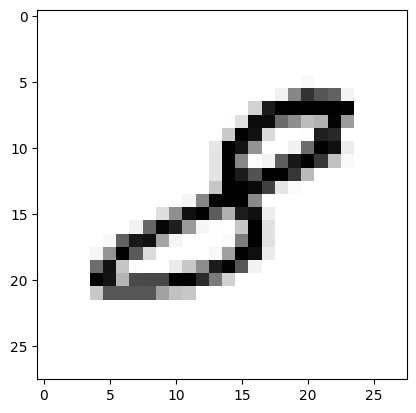

In [16]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()